<a href="https://colab.research.google.com/github/alexathomases/resource-allocation/blob/main/CovidResourceAllocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import numpy as np
import torch.utils.data
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
!pip install EoN
import EoN

     |████████████████████████████████| 113 kB 4.7 MB/s 
  Created wheel for EoN: filename=EoN-1.1-py3-none-any.whl size=120819 sha256=bb62b7fe63578545ed6fe41f76e276f49be0668231f62ab53e0776c79cd82d32
  Stored in directory: /root/.cache/pip/wheels/0b/c0/a4/d6001fd809cb84c027ada5c2ab3b6d1cb2e97fec3f9978eae7
Successfully built EoN


# Constructing input network

In [ ]:
contacts_df = pd.read_excel(r"tij_SFHH.xlsx", header=None)
contacts_list = contacts_df.values.tolist()
G = nx.Graph(contacts_list)

In [ ]:
num_nodes = nx.number_of_nodes(G)
num_edges = nx.number_of_edges(G)
num_isolates = len(list(nx.isolates(G)))
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Number of isolated nodes:", num_isolates)

Number of nodes: 403
Number of edges: 9565
Number of isolated nodes: 0


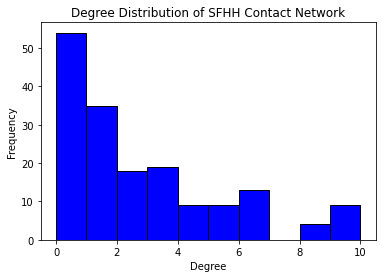

In [ ]:
degree_dist = nx.degree_histogram(G)
plt.hist(degree_dist, color = 'blue', edgecolor = 'black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title("Degree Distribution of SFHH Contact Network")
plt.show()

In [ ]:
clustering_coef = np.mean(list(nx.clustering(G).values()))
diameter = nx.diameter(G)
print("Clustering coefficient:", clustering_coef)
print("Diameter:", diameter)

Clustering coefficient: 0.2817613806101428
Diameter: 4


In [ ]:
nodes = nx.nodes(G)

In [ ]:
# Census 2020 data

female_prob = 0.508
poverty_prob = 0.114
under_5 = 0.06
five_to18 = 0.123
over65 = 0.165
eighteen_to_65 = 1 - (under_5 + five_to18 + over65)
white_not_hispanic = 0.601
hispanic = 0.185
black = 0.134
asian = 0.059
native_american = 0.013
other_race = 1 - (white_not_hispanic + hispanic + black + asian + native_american)


In [ ]:
# https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-race-ethnicity.html
# CDC data

hispanic_weight = 1.5
na_weight = 1.5
asian_weight = 0.7
white_weight = 1.0
black_weight = 1.0

under_5_weight = 0.9
over_65_weight = 1.2

# Weighting nodes

In [ ]:
under_5_cutoff = int(under_5 * num_nodes)
over_65_cutoff = num_nodes - int(over65 * num_nodes)
age_weights = np.ones(num_nodes)
age_weights[0:under_5_cutoff] = under_5_weight
age_weights[over_65_cutoff:] = over_65_weight
shuffled_age_weights = np.array(np.random.shuffle(age_weights))

In [ ]:
hisp_cutoff = int(hispanic * num_nodes)
na_cutoff = hisp_cutoff + int(native_american * num_nodes)
asian_cutoff = na_cutoff + int(asian * num_nodes)
black_cutoff = asian_cutoff + int(black * num_nodes)
race_weights = np.ones(num_nodes)
race_weights[0:hisp_cutoff] = hispanic_weight
race_weights[hisp_cutoff:na_cutoff] = na_weight
race_weights[na_cutoff:asian_cutoff] = asian_weight
race_weights[asian_cutoff:black_cutoff] = black_weight
shuffled_race_weights = np.array(np.random.shuffle(race_weights))

In [ ]:
final_weights = np.multiply(age_weights, race_weights)
nodes = np.array(nodes)

In [ ]:
edges = nx.edges(G)
node_weights = {nodes[i]: final_weights[i] for i in range(num_nodes)}
edge_weights = {edge: node_weights[edge[0]] * node_weights[edge[1]] for edge in edges}
nx.set_edge_attributes(G, edge_weights, name = "weight")
G.edges(data = True)

EdgeDataView([(1467, 1591, {'weight': 1.5}), (1467, 1562, {'weight': 1.5}), (1467, 1513, {'weight': 1.5}), (1467, 1527, {'weight': 1.5}), (1467, 1504, {'weight': 1.5}), (1467, 1700, {'weight': 1.5}), (1467, 1842, {'weight': 1.5}), (1467, 1858, {'weight': 1.7999999999999998}), (1467, 1531, {'weight': 1.5}), (1467, 1769, {'weight': 1.5}), (1467, 1493, {'weight': 1.5}), (1467, 1443, {'weight': 1.7999999999999998}), (1467, 1495, {'weight': 1.5}), (1467, 1461, {'weight': 1.5}), (1467, 1644, {'weight': 1.5}), (1467, 1740, {'weight': 1.35}), (1467, 1581, {'weight': 1.5}), (1467, 1572, {'weight': 1.5}), (1467, 1757, {'weight': 1.5}), (1467, 1911, {'weight': 2.25}), (1467, 1711, {'weight': 1.0499999999999998}), (1467, 1626, {'weight': 1.35}), (1467, 1630, {'weight': 1.5}), (1467, 1761, {'weight': 1.7999999999999998}), (1467, 1698, {'weight': 1.5}), (1467, 1707, {'weight': 1.35}), (1467, 1441, {'weight': 1.5}), (1467, 1552, {'weight': 1.5}), (1467, 1683, {'weight': 1.7999999999999998}), (1467, 1

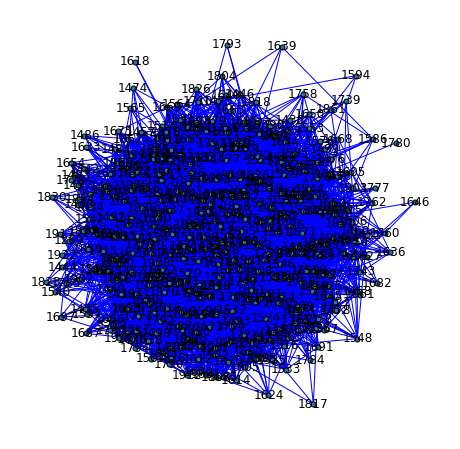

In [ ]:
prog = 'neato'
pos = nx.nx_pydot.graphviz_layout(G, prog)
plt.figure(figsize=(8, 8))
plt.axis('off')
nx.draw_networkx(G, pos=pos, with_labels=True, node_size=25, edgecolors='black', edge_color='b')
plt.show()

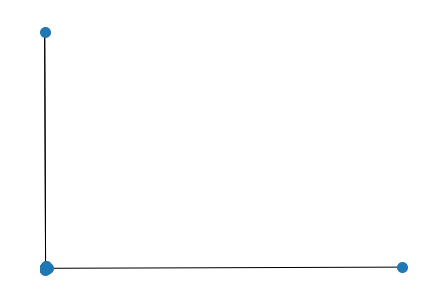

In [ ]:
options = {"node_color": "C0", "node_size": 100}
nx.draw_spectral(G, **options)

# Simulate outbreak

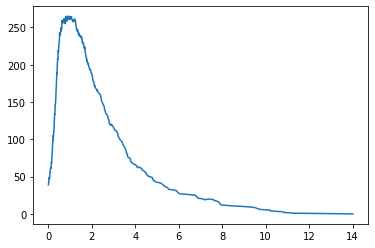

In [ ]:
# Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
initial_fraction_infected = 0.096 # https://www.mayoclinic.org/coronavirus-covid-19/map
gamma = 0.5
tau = 0.1
time, S, I, R = EoN.fast_SIR(G, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")

plt.plot(time, I)

In [ ]:
print("Number of infected nodes at end of simulation: ", I[-1])
print("Number of infected nodes at end of simulation: ", I[-1] / num_nodes)

Number of infected nodes at end of simulation:  0
Number of infected nodes at end of simulation:  0.0


In [ ]:
print(node_weights)

{1467: 1.0, 1591: 1.0, 1513: 1.0, 1568: 1.5, 1562: 1.0, 1524: 1.0, 1771: 1.5, 1428: 0.7, 1600: 1.0, 1523: 0.9, 1525: 1.2, 1529: 1.0, 1544: 1.0, 1519: 1.5, 1583: 1.0, 1510: 1.0, 1549: 1.5, 1553: 1.0, 1606: 1.0, 1622: 1.0, 1599: 1.0, 1560: 1.0, 1602: 1.2, 1631: 1.0, 1573: 1.0, 1537: 1.0, 1531: 1.0, 1539: 1.0, 1604: 1.2, 1543: 1.0, 1526: 1.2, 1582: 0.84, 1551: 1.0, 1269: 1.0, 1463: 1.0, 1628: 1.0, 1552: 1.5, 1514: 1.5, 1547: 1.0, 1504: 0.7, 1601: 1.5, 1629: 1.0, 1616: 1.2, 1518: 1.7999999999999998, 1691: 1.0, 1545: 1.0, 1580: 1.0, 1569: 1.0, 1520: 0.7, 1742: 1.0, 1430: 0.9, 1453: 0.9, 1563: 0.7, 1618: 1.5, 1434: 0.9, 1448: 1.0, 1487: 1.0, 1626: 1.0, 1512: 1.0, 1527: 1.0, 1592: 1.2, 1437: 1.0, 1542: 1.0, 1461: 0.7, 1627: 1.2, 1578: 1.2, 1594: 1.5, 1521: 1.5, 1593: 1.0, 1793: 1.5, 1598: 1.0, 1655: 1.0, 1436: 1.5, 1724: 0.7, 1469: 1.0, 1489: 1.2, 1853: 1.0, 1915: 1.0, 1451: 1.5, 1459: 1.7999999999999998, 1441: 1.0, 1789: 1.0, 1920: 1.2, 1538: 1.0, 1874: 1.0, 1574: 1.2, 1532: 1.0, 1617: 1.0, 

In [ ]:
weighted_nodes_graph = G.copy()
nx.set_node_attributes(weighted_nodes_graph, node_weights, name="weight")

In [ ]:
closeness = nx.closeness_centrality(G)
num_resources = 50

# NetworkX Approximation

In [ ]:
from networkx.algorithms.approximation import vertex_cover
nx_cover = vertex_cover.min_weighted_vertex_cover(weighted_nodes_graph, "weight")
print(len(nx_cover))
nx_cover_sorted = sorted(nx_cover, key=lambda x: closeness[x], reverse=True)
nx_cover_top = nx_cover_sorted[0:num_resources]

382


[1618, 1780]


EdgeDataView([(1467, 1591, {'weight': 1.5}), (1467, 1513, {'weight': 1.5}), (1467, 1504, {'weight': 1.5}), (1467, 1700, {'weight': 1.5}), (1467, 1842, {'weight': 1.5}), (1467, 1858, {'weight': 1.7999999999999998}), (1467, 1769, {'weight': 1.5}), (1467, 1493, {'weight': 1.5}), (1467, 1443, {'weight': 1.7999999999999998}), (1467, 1495, {'weight': 1.5}), (1467, 1461, {'weight': 1.5}), (1467, 1644, {'weight': 1.5}), (1467, 1740, {'weight': 1.35}), (1467, 1581, {'weight': 1.5}), (1467, 1572, {'weight': 1.5}), (1467, 1757, {'weight': 1.5}), (1467, 1911, {'weight': 2.25}), (1467, 1711, {'weight': 1.0499999999999998}), (1467, 1626, {'weight': 1.35}), (1467, 1630, {'weight': 1.5}), (1467, 1552, {'weight': 1.5}), (1467, 1683, {'weight': 1.7999999999999998}), (1467, 1904, {'weight': 1.5}), (1467, 1477, {'weight': 1.5}), (1467, 1905, {'weight': 1.5}), (1467, 1476, {'weight': 1.5}), (1467, 1712, {'weight': 1.5}), (1467, 1706, {'weight': 2.25}), (1467, 1566, {'weight': 2.25}), (1467, 1807, {'weight'

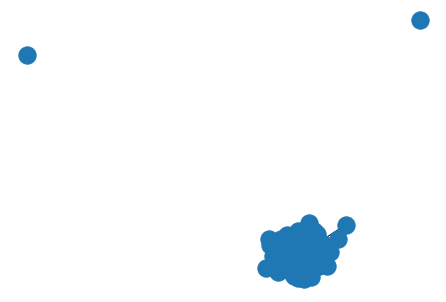

In [ ]:
nx_solution = weighted_nodes_graph.copy()
nx_solution.remove_nodes_from(nx_cover_top)
print(list(nx.isolates(nx_solution)))
nx.draw(nx_solution)
nx_solution.edges(data=True)

Number of infected nodes at end of simulation:  234
Infection rate at end of simulation:  0.6628895184135978


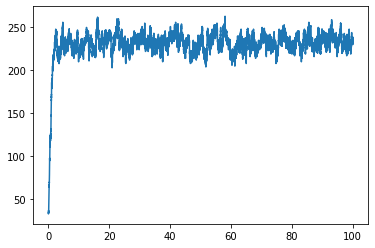

In [ ]:
# Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
initial_fraction_infected = 0.096 # https://www.mayoclinic.org/coronavirus-covid-19/map
gamma = 1.0
tau = 0.1
time, S, I = EoN.fast_SIS(nx_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")

plt.plot(time, I)
print("Number of infected nodes at end of simulation: ", I[-1])
print("Infection rate at end of simulation: ", I[-1] / len(nx_solution.nodes()))

# Control: Top Weights

43
Nodes in control top 50 that aren't in NX solution top 50: [1583, 1549, 1580, 1512, 1521, 1772, 1739, 1642, 1765, 1862, 1802, 1708, 1467, 1529, 1539, 1616, 1742, 1542, 1793, 1469, 1538, 1874, 1903, 1839, 1872, 1452, 1559, 1557, 1460, 1608, 1528, 1650, 1790, 1435, 1505, 1659, 1696, 1706, 1783, 1640, 1749, 1639, 1811]
[]
False


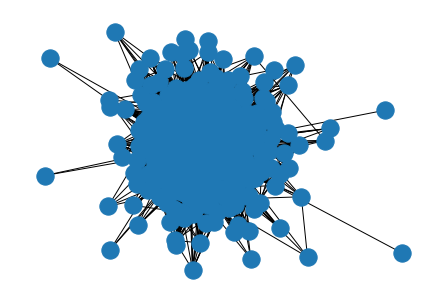

In [ ]:
topweights_solution = G.copy()
topweights_cover = nodes
topweights_cover_sorted = sorted(topweights_cover, key=lambda x: node_weights[x], reverse=True)
topweights_cover_top = topweights_cover_sorted[0:num_resources]
topweights_solution.remove_nodes_from(topweights_cover_top)
notin = [ele for ele in topweights_cover_top if ele not in nx_cover_top]
print(len(notin))
print("Nodes in control top 50 that aren't in NX solution top 50:", notin)
print(list(nx.isolates(topweights_solution)))
nx.draw(topweights_solution)
topweights_solution.edges(data=True)
print(nx.is_isomorphic(topweights_solution, nx_solution))

# Control: Top Closeness Centrality Nodes

Nodes in control top 50 that aren't in NX solution top 50: [1591, 1600]
[1618, 1780]
False


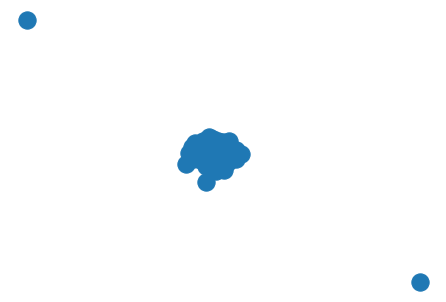

In [ ]:
control_solution = G.copy()
control_cover = nodes
control_cover_sorted = sorted(control_cover, key=lambda x: closeness[x], reverse=True)
control_cover_top = control_cover_sorted[0:num_resources]
control_solution.remove_nodes_from(control_cover_top)
notin = [ele for ele in control_cover_top if ele not in nx_cover_top]
print("Nodes in control top 50 that aren't in NX solution top 50:", notin)
print(list(nx.isolates(control_solution)))
nx.draw(control_solution)
control_solution.edges(data=True)
print(nx.is_isomorphic(control_solution, nx_solution))

Number of infected nodes at end of simulation:  225
Infection rate at end of simulation:  0.6373937677053825


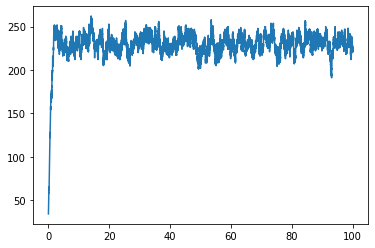

In [ ]:
# Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
initial_fraction_infected = 0.096 # https://www.mayoclinic.org/coronavirus-covid-19/map
gamma = 1.0
tau = 0.1
time, S, I = EoN.fast_SIS(control_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")

plt.plot(time, I)
print("Number of infected nodes at end of simulation: ", I[-1])
print("Infection rate at end of simulation: ", I[-1] / len(control_solution.nodes()))

# MAE-HTS Algorithm

In [ ]:
def Graph_Reduction(g1):
  v_s = []
  g = g1.copy()
  r = nx.Graph([])
  while nx.is_isomorphic(g, r) == False:
    r = g.copy()
    gnodes = nx.nodes(g)
    removed = []
    for node in list(gnodes):
      if node in removed:
        continue
      neighbors = np.array([n for n in g.neighbors(node)])
      if len(neighbors) == 0:
        break
      neigh_one = list(filter(lambda x: g.degree(x) == 1, neighbors))
      neighbor_weights = [g.nodes[n]["weight"] for n in neighbors]
      if g.nodes[node]["weight"] >= sum(neighbor_weights):  # adjacency rule
        g.remove_nodes_from(neighbors)
        g.remove_node(node)
        removed.extend(neighbors)
        removed.append(node)
        v_s.extend(neighbors)
      if len(neigh_one) != 0:
        neigh_one_weights = [g.nodes[n]["weight"] for n in neigh_one]
        if g.nodes[node]["weight"] >= sum(neigh_one_weights): # degree-one rule
          g.remove_nodes_from(neigh_one)
          g.remove_node(node)
          removed.extend(neigh_one)
          removed.append(node)
          v_s.append(node)
  return r, v_s

In [ ]:
import random

def Init(g):
  v_prime = []
  e_prime = edges
  uncovered_edges = nx.to_edgelist(g)
  iter = 0
  while len(e_prime) > 0 and iter < 2000:
    uncovered_edges = list(filter(lambda x: x[0] not in v_prime and x[1] not in v_prime, uncovered_edges))
    v_c_one = [x[0] for x in uncovered_edges]
    v_c_two = [x[1] for x in uncovered_edges]
    v_c = list(set().union(v_c_one, v_c_two))
    v_e = [(v, g.nodes[v]["weight"] / np.sum(g.neighbors(v) not in v_prime)) for v in v_c]
    k = len(v_c)
    if k == 0:
      print(len(v_prime))
      break
    v_e.sort(key = lambda x: x[1])
    v_e = v_e[0:k]
    probs = []
    for i in range(len(v_e)):
      probs.append(i / (1 + k) * (k / 2))
    v_star = random.choices(v_e, weights = probs)[0]
    v_prime.append(v_star[0])
    e_prime = [ele for ele in e_prime if ele not in g.edges(v_star)]
    iter += 1
  return v_prime

In [ ]:
def Crossover(s1, s2):
  s1_prime = [v for v in s1 if v in s2]
  s2_prime = s1_prime.copy()
  uncovered_edges1 = edges
  uncovered_edges1 = list(filter(lambda x: x[0] not in s1_prime and x[1] not in s1_prime, uncovered_edges1))
  uncovered_edges2 = uncovered_edges1.copy()
  while len(uncovered_edges1) > 0:
    candidates = [e[0] for e in uncovered_edges1]
    candidates.extend([e[1] for e in uncovered_edges1])
    candidates = list(set(candidates))
    v = np.random.choice(candidates)
    s1_prime.append(v)
    newly_covered = list(filter(lambda x: x[0] == v or x[1] == v, uncovered_edges1))
    uncovered_edges1 = list(filter(lambda x: x not in newly_covered, uncovered_edges1))
  while len(uncovered_edges2) > 0:
    candidates = [e[0] for e in uncovered_edges2]
    candidates.extend([e[1] for e in uncovered_edges2])
    candidates = list(set(candidates))
    v = np.random.choice(candidates)
    s2_prime.append(v)
    newly_covered = list(filter(lambda x: x[0] == v or x[1] == v, uncovered_edges2))
    uncovered_edges2 = list(filter(lambda x: x not in newly_covered, uncovered_edges2))
  return s1_prime, s2_prime

In [ ]:
def isFeasible(full_g, cov):
  full_edges = set(nx.edges(full_g))
  covered = set()
  for v in cov:
    lst = list(full_g.edges(v))
    filt = [l for l in lst if l in full_edges]
    covered.update(filt)
  uncovered = full_edges.difference(covered)
  return len(uncovered) == 0, covered

In [ ]:
import math

def HTS(wnodes_graph, g_prime, v_prime):
  initial_weights = [wnodes_graph.nodes[n]["weight"] for n in v_prime]
  all_weights = {n: wnodes_graph.nodes[n]["weight"] for n in wnodes_graph}
  iw = sum(initial_weights)
  improved = v_prime.copy()
  edges = nx.edges(wnodes_graph)
  dyn_weights = {edge: 1 for edge in edges}
  hash1 = 0
  hash2 = 0
  hash3 = 0
  gamma1 = 1.3
  gamma2 = 1.5
  gamma3 = 1.8
  scores = []
  for iter in range(5):
    feas, covered = isFeasible(wnodes_graph, v_prime)
    prime_weights = [wnodes_graph.nodes[n]["weight"] for n in v_prime]
    while feas:
      improved_weights = [wnodes_graph.nodes[n]["weight"] for n in improved]
      prime_weights = [wnodes_graph.nodes[n]["weight"] for n in v_prime]
      if sum(improved_weights) > sum(prime_weights):
        improved = v_prime.copy()
      for i in len(v_prime):
        hash1 += math.floor(i ** gamma1) * v_prime[i]
        hash2 += math.floor(i ** gamma2) * v_prime[i]
        hash3 += math.floor(i ** gamma3) * v_prime[i]
      H1[hash1] = 1
      H2[hash2] = 1
      H3[hash3] = 1
      # find vertex w greatest score
      cost = 0
      max_score = -1 * np.inf
      max_node = 0
      for edge in covered:
        cost += dyn_weights[edge]
      for v in v_prime:
        new_covered = []
        cost2 = 0
        for edge in covered:
          if edge[0] != v and edge[1] != v:
            new_covered.append(edge)
        for edge in new_covered:
          cost2 += dyn_weights[edge]
        score = (cost - cost2) / all_weights[v]
        if score > max_score:
          max_node = v
          max_score = score
      v_prime.remove(max_node)
    # find vertex w greatest score
    cost = 0
    max_score = -1 * np.inf
    max_node = 0
    for edge in covered:
      cost += dyn_weights[edge]
    for v in v_prime:
      new_covered = []
      cost2 = 0
      for edge in covered:
        if edge[0] != v and edge[1] != v:
          new_covered.append(edge)
      for edge in new_covered:
        cost2 += dyn_weights[edge]
      score = (cost - cost2) / all_weights[v]
      if score > max_score:
        max_node = v
        max_score = score
    tabu_list = []
    feas, covered = isFeasible(wnodes_graph, v_prime) 
    prime_weights = [wnodes_graph.nodes[n]["weight"] for n in v_prime]
    while not feas:
      # find vertex w greatest score
      cost = 0
      max_score = -1 * np.inf
      max_node = 0
      prime_weights = [wnodes_graph.nodes[n]["weight"] for n in v_prime]
      for edge in covered:
        cost += dyn_weights[edge]
      for v in set(wnodes_graph.nodes()).difference(improved):
        new_covered = []
        cost2 = 0
        for edge in covered:
          if edge[0] != v and edge[1] != v:
            new_covered.append(edge)
        for edge in new_covered:
          cost2 += dyn_weights[edge]
        score = (cost - cost2) / all_weights[v]
        if score > max_score:
          max_node = v
          max_score = score
      prime_weights = [wnodes_graph.nodes[n]["weight"] for n in v_prime]
      if sum(prime_weights) + wnodes_graph.nodes[max_node]["weight"] >= iw:
        break
      v_prime.add(max_node)
      tabu_list.add(max_node)
    iter += 1
  return improved  


In [ ]:
import time

def MAE_HTS(wnodes_graph):
  start = time.time()
  iter_cycle = 5
  g_prime, v_s = Graph_Reduction(wnodes_graph)
  s1 = Init(wnodes_graph)
  s2 = Init(wnodes_graph)
  s_p = Init(wnodes_graph)
  s_c = Init(wnodes_graph)
  s_best = Init(wnodes_graph)
  gen = 0
  cycle = 0
  while time.time() - start <= 120:
    s1_prime, s2_prime = Crossover(s1, s2)
    s1 = HTS(wnodes_graph, g_prime, s1_prime)
    s2 = HTS(wnodes_graph, g_prime, s2_prime)
    s1_weights = [wnodes_graph.nodes[n]["weight"] for n in s1]
    s2_weights = [wnodes_graph.nodes[n]["weight"] for n in s2]
    sc_weights = [wnodes_graph.nodes[n]["weight"] for n in s_c]
    best_index = np.argmin([sum(s1_weights), sum(s2_weights), sum(sc_weights)])
    if best_index == 0:
      s_c = s1.copy()
    elif best_index == 1:
      s_c = s2.copy()
    sbest_weights = [wnodes_graph.nodes[n]["weight"] for n in s_best]
    best_index = np.argmin([sum(sc_weights), sum(sbest_weights)])
    if best_index == 0:
      s_best = s_c.copy()
    if gen % iter_cycle == 0:
      s_1 = s_p.copy()
      s_p = s_c.copy()
      s_c = Init(wnodes_graph)
      cycle += 1
    gen += 1
  s_best.append(v_s[0])
  return set(s_best)

In [ ]:
H1 = {}
H2 = {}
H3 = {}
cover = MAE_HTS(weighted_nodes_graph)
print(cover)

{'weight': 1.0}
{'weight': 1.0}
end of HTS iter 0
end of HTS iter 1
end of HTS iter 2
end of HTS iter 3
end of HTS iter 4
end of HTS iter 0
end of HTS iter 1
end of HTS iter 2
end of HTS iter 3
end of HTS iter 4
{'weight': 1.0}
end of HTS iter 0
end of HTS iter 1
end of HTS iter 2
end of HTS iter 3
end of HTS iter 4
end of HTS iter 0
end of HTS iter 1
end of HTS iter 2
end of HTS iter 3
end of HTS iter 4
sbest update [1890, 1915, 1460, 1519, 1533, 1572, 1818, 1528, 1880, 1575, 1803, 1839, 1698, 1755, 1717, 1790, 1887, 1628, 1804, 1426, 1484, 1885, 1525, 1564, 1594, 1448, 1583, 1543, 1656, 1449, 1902, 1694, 1438, 1914, 1545, 1851, 1835, 1613, 1631, 1535, 1874, 1549, 1906, 1918, 1701, 1676, 1903, 1760, 1467, 1739, 1629, 1735, 1893, 1761, 1900, 1695, 1783, 1862, 1606, 1742, 1477, 1697, 1638, 1512, 1474, 1580, 1684, 1841, 1718, 1555, 1840, 1659, 1677, 1428, 1847, 1769, 1626, 1774, 1749, 1796, 1792, 1664, 1667, 1505, 1725, 1773, 1499, 1473, 1777, 1552, 1857, 1872, 1813, 1608, 1566, 1441, 19

In [ ]:
print(len(cover))
print(len(set(cover)))

379
379


In [ ]:
sorted_cover = sorted(cover, key=lambda x: closeness[x], reverse=True)
top_fifty = sorted_cover[0:num_resources]

In [ ]:
mae_hts_g = G.copy()
mae_hts_g.remove_nodes_from(top_fifty)
notin = [ele for ele in control_cover_top if ele not in top_fifty]
print("Nodes in control top 50 that aren't in MAE-HTS solution top 50:", notin)
print(list(nx.isolates(mae_hts_g)))
mae_hts_g.edges(data=True)
print(nx.is_isomorphic(control_solution, nx_solution))

Nodes in control top 50 that aren't in MAE-HTS solution top 50: [1591, 1600]
[1618, 1780]
False


Number of infected nodes at end of simulation:  225
Infection rate at end of simulation:  0.6373937677053825


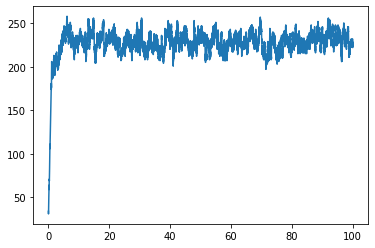

In [ ]:
# Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
initial_fraction_infected = 0.096 # https://www.mayoclinic.org/coronavirus-covid-19/map
gamma = 1.0
tau = 0.1
time, S, I = EoN.fast_SIS(mae_hts_g, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")

plt.plot(time, I)
print("Number of infected nodes at end of simulation: ", I[-1])
print("Infection rate at end of simulation: ", I[-1] / len(mae_hts_g.nodes()))

# Experiments

In [ ]:
trials = 10
initial_fraction_infected = 0.096 # https://www.mayoclinic.org/coronavirus-covid-19/map
gamma = 1.0 # scales recovery rate
tau = 0.1 # scales transmission rate

In [ ]:
# No intervention

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(G, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1]

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(G.nodes())))

Avg infection rate at end of simulation:  0.7645161290322581


In [ ]:
# Top weights solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(topweights_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1] # + 50?

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(topweights_solution.nodes())))

Avg infection rate at end of simulation:  0.726628895184136


In [ ]:
# Control solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(control_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1] # + 50?

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(control_solution.nodes())))

Avg infection rate at end of simulation:  0.6572237960339944


In [ ]:
# NX solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(nx_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1]

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(nx_solution.nodes())))

Avg infection rate at end of simulation:  0.6575070821529745


In [ ]:
# MAE-HTS solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(mae_hts_g, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1]

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(mae_hts_g.nodes())))

Avg infection rate at end of simulation:  0.6558073654390935


In [ ]:
trials = 10
initial_fraction_infected = 0.096 # https://www.mayoclinic.org/coronavirus-covid-19/map
gamma = 0.8
tau = 0.3

# No intervention

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(G, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1]

print("No intervention Avg infection rate at end of simulation: ", total_infected / (trials * len(G.nodes())))

# Control solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(control_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1] # + 50?

print("Control Avg infection rate at end of simulation: ", total_infected / (trials * len(control_solution.nodes())))

# NX solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(nx_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1]

print("NX Avg infection rate at end of simulation: ", total_infected / (trials * len(nx_solution.nodes())))

# MAE-HTS solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(mae_hts_g, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1]

print("MAE-HTS Avg infection rate at end of simulation: ", total_infected / (trials * len(mae_hts_g.nodes())))

No intervention Avg infection rate at end of simulation:  0.924317617866005
Control Avg infection rate at end of simulation:  0.8844192634560907
NX Avg infection rate at end of simulation:  0.8937677053824362
MAE-HTS Avg infection rate at end of simulation:  0.8779036827195468


In [ ]:
trials = 10
initial_fraction_infected = 0.096 # https://www.mayoclinic.org/coronavirus-covid-19/map
gamma = 0.8
tau = 0.3

# Top weights solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(topweights_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1] # + 50?

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(topweights_solution.nodes())))

Avg infection rate at end of simulation:  0.9008498583569405


In [ ]:
trials = 10
initial_fraction_infected = 0.096 # https://www.mayoclinic.org/coronavirus-covid-19/map
gamma = 1.2
tau = 0.05

# No intervention

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(G, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1]

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(G.nodes())))

# Control solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(control_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1] # + 50?

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(control_solution.nodes())))

# NX solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(nx_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1]

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(nx_solution.nodes())))

# MAE-HTS solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(mae_hts_g, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1]

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(mae_hts_g.nodes())))

Avg infection rate at end of simulation:  0.5573200992555831
Avg infection rate at end of simulation:  0.3546742209631728
Avg infection rate at end of simulation:  0.3620396600566572
Avg infection rate at end of simulation:  0.37110481586402266


In [ ]:
trials = 10
initial_fraction_infected = 0.096 # https://www.mayoclinic.org/coronavirus-covid-19/map
gamma = 1.2
tau = 0.05

# Top weights solution

total_infected = 0
for i in range(trials):
    # Use fast_SIS on EoN to simulate an epidemic with no immunity upon recovery
    time, S, I = EoN.fast_SIS(topweights_solution, tau, gamma, tmax = 100, rho = initial_fraction_infected, transmission_weight = "weight")
    total_infected += I[-1] # + 50?

print("Avg infection rate at end of simulation: ", total_infected / (trials * len(topweights_solution.nodes())))

Avg infection rate at end of simulation:  0.4628895184135977


# Determine demographics of covers

In [ ]:
# Control cover
total_weight = 0
for n in control_cover_top:
  total_weight += node_weights[n]
print("Total weight of nodes in control cover:", total_weight)

Total weight of nodes in control cover: 54.839999999999996


In [ ]:
# Top weights cover
total_weight = 0
for n in topweights_cover_top:
  total_weight += node_weights[n]
print("Total weight of nodes in control cover:", total_weight)

Total weight of nodes in control cover: 78.9


In [ ]:
# NX cover
total_weight = 0
for n in nx_cover_top:
  total_weight += node_weights[n]
print("Total weight of nodes in NX cover:", total_weight)

Total weight of nodes in NX cover: 55.13999999999999


In [ ]:
# MAE-HTS cover
total_weight = 0
for n in top_fifty:
  total_weight += node_weights[n]
print("Total weight of nodes in MAE-HTS cover:", total_weight)

Total weight of nodes in MAE-HTS cover: 55.13999999999999
